# Test the Solvers on Stiff Equations

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), ".."))
import rungekutta as rk
import numpy as np
import pandas as pd
from plotnine import *
import time
import scipy.integrate
import warnings
warnings.filterwarnings('ignore')

## System
Test on the system:
$
m\frac{d^2x}{dt^2}+c\frac{dx}{dt}+kx=0,\\
x(0)=x_0,\quad\dot{x}(0)=0
$
Letting:
$
\kappa = \frac{k}{m}\quad\text{and}\quad\nu=\frac{c}{m}
$
This can be split into a sytem of 1st order ODEs:
$
\frac{dx}{dt} = u\\
\frac{du}{dt} = -\kappa x - \nu u
$
Equivalently:
$
\left(\begin{array}{c}
    \frac{dx}{dt} \\ \frac{du}{dt}
\end{array}\right)=
\left(\begin{array}{cc}
    0 & 1 \\ -\kappa & -\nu
\end{array}\right)
\left(\begin{array}{c}
    x \\ u
\end{array}\right)
$

In [2]:
class System:
    def __init__(self, kappa, nu):
        self.kappa = kappa; self.nu = nu
        self.A = np.array([
            [0,1],[-self.kappa, -self.nu]], dtype=float)

    def rhs(self, y, t):
        return np.array([
            y[1], -self.kappa*y[0] - self.nu*y[1]
        ], dtype=float)

    def matrix(self, t):
        return self.A

df_performance = pd.DataFrame(columns=('method', 'step_size', 'converges', 'error', 'time'))
system = System(1000, 1000)
system.initialY = [0, 1]

## Create times and scipy solution at these times
times = np.linspace(0, 4, 40)
scipy_solution = scipy.integrate.odeint(system.rhs, system.initialY, times) 


### Solve System using Scipy

In [3]:
## Perfrom analytic Solution
df_analytic = pd.DataFrame(columns=('x', 't'))
log_times = np.logspace(-5, 0.5, 400)
sln = scipy.integrate.odeint(system.rhs, system.initialY, log_times) 
for i in range(len(log_times)):
    df_analytic = df_analytic.append({
        'x': sln[i,0], 't':log_times[i]
    }, ignore_index=True)

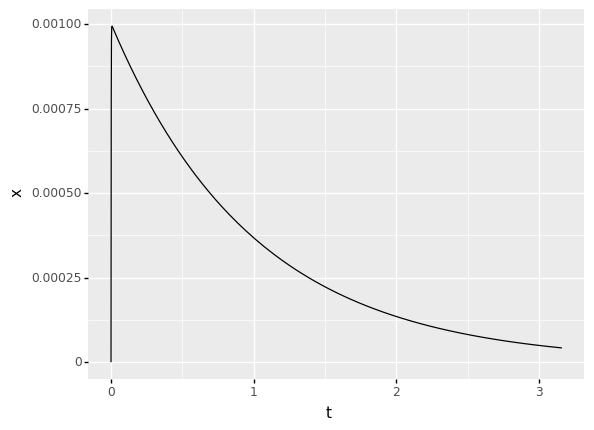

<ggplot: (8762871284351)>

In [4]:
(
    ggplot(df_analytic, aes(x='t', y='x')) +
    geom_line()
)

#### Plot on Log scale for Time

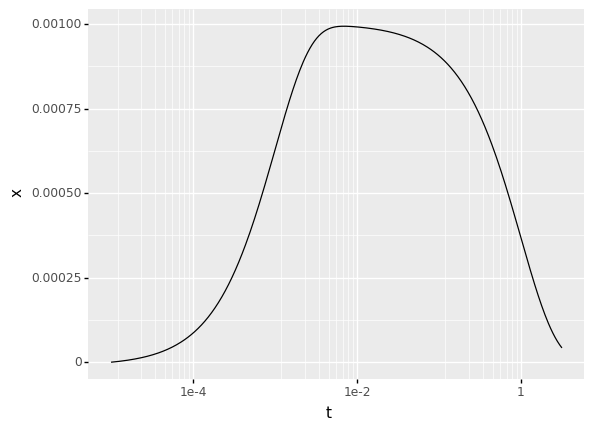

<ggplot: (8762871280677)>

In [5]:
(
    ggplot(df_analytic, aes(x='t', y='x')) +
    geom_line() + scale_x_log10()
)

System is stiff, requires a very small step size at small t. Some numerical methods may explode unless step size is very small

In [6]:
## Helper method
def try_solve_and_compare(solver: rk.RKSolver, step_size=0.001, isExplicit=True):
    try:
        t0 = time.perf_counter()
        sln = solver.solve_times(times, system.rhs if isExplicit else system.matrix,
            y0=system.initialY, t0=0, step_size = step_size)
        t1 = time.perf_counter()
    except Exception as e:
        return None, None, None
    if not np.all(np.isfinite(sln)):
        return None, None, None
    err = np.sqrt(np.mean(np.power(sln[:, 0] - scipy_solution[:, 0], 2)))
    return sln[:, 0], err, t1-t0

## Test Solvers
### Make Solvers

In [7]:
explicit_solvers = {
    'forward_euler': rk.forward_euler(),
    'explicit_midpoint': rk.explicit_midpoint(),
    'fourth_order_runge_kutta': rk.fourth_order_runge_kutta(),
    'dormand_prince': rk.dormand_prince()}

implicit_solvers={
    'backward_euler': rk.backward_euler(),
    'implicit_midpoint': rk.implicit_midpoint(),
    'crank_nicolson': rk.crank_nicolson(),
    'order_4_gauss_legendre': rk.gauss_legendre_order_four(),
    'order_6_guss_legendre': rk.gauss_legendre_order_six()
}

### Run Tests

In [8]:
for solver in explicit_solvers:
    for s in np.logspace(-3, -2, 200):
        print(f'\rSolving using {solver}, step_size {s:.3e}.' + ' '*50, end='')
        sln, err, t = try_solve_and_compare(explicit_solvers[solver], step_size=s, isExplicit=True)
        if sln is not None:
            df_performance = df_performance.append({'method': solver, 'step_size': s, 'converges': np.isfinite(err) and err < 1, 'error': err, 'time': t}, ignore_index=True)
        else:
            df_performance = df_performance.append({'method': solver, 'step_size': s, 'converges': False}, ignore_index=True)

for solver in implicit_solvers:
    for s in np.logspace(-3, -1, 50):
        print(f'\rSolving using {solver}, step_size {s:.3e}.' + ' '*50, end='')
        sln, err, t = try_solve_and_compare(implicit_solvers[solver], step_size=s, isExplicit=False)
        if sln is not None:
            df_performance = df_performance.append({'method': solver, 'step_size': s, 'converges': np.isfinite(err) and err < 1, 'error': err, 'time': t}, ignore_index=True)
        else:
            df_performance = df_performance.append({'method': solver, 'step_size': s, 'converges': False}, ignore_index=True)

Solving using order_6_guss_legendre, step_size 1.000e-01.                                                     

### Find the Maximum Step Size that converged for each method

In [9]:
df_best = df_performance.query('converges==True').groupby('method').max('step_size')

,step_size,error,time
method,,,
backward_euler,0.100000,0.077892,0.313813
crank_nicolson,0.100000,0.035680,0.438841
dormand_prince,0.003293,0.000064,0.213658
explicit_midpoint,0.002002,0.001225,0.076211
forward_euler,0.002002,0.001225,0.069282
fourth_order_runge_kutta,0.002768,0.000055,0.148548
implicit_midpoint,0.100000,0.035680,0.292314
order_4_gauss_legendre,0.091030,0.952308,0.433233
order_6_guss_legendre,0.100000,0.037722,0.555350


Implicit solvers are much more computationally expensive, but they are much more stable. If the equations are stiff, explicit methods require a very small time step to converge, whereas implicit methods will still converge on larger timescales. Therefore for stiff systems it may be faster to use implicit methods on a long timescale instead of using tiny step sizes so the explicit methods converge.

### Plot errors

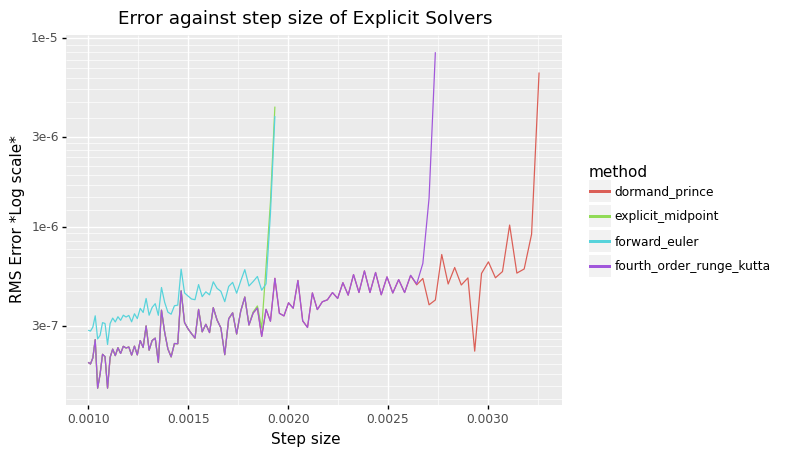

<ggplot: (8762869060789)>

In [10]:
(
    ggplot(df_performance[df_performance.method.isin(explicit_solvers.keys())].query('converges==True and error<1e-5'), aes(x='step_size', y='error', colour='method')) +
    geom_line(aes(group='method')) +
    scale_y_log10() +
    ylab('RMS Error *Log scale*') + xlab('Step size') +
    ggtitle('Error against step size of Explicit Solvers')
)

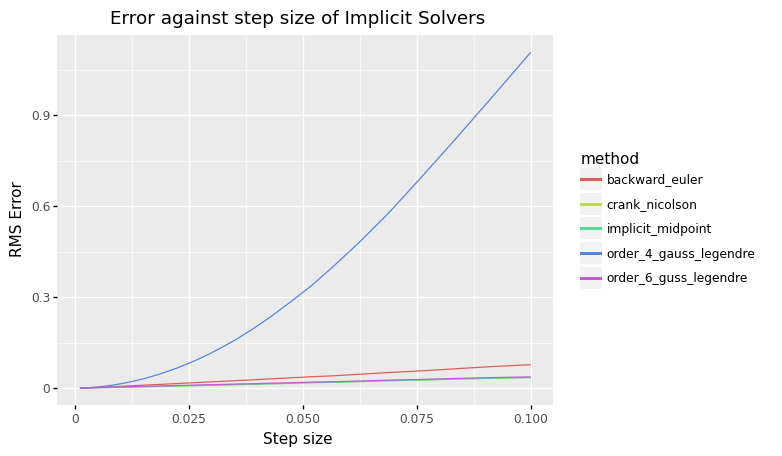

<ggplot: (8762868946167)>

In [11]:
(
    ggplot(df_performance[df_performance.method.isin(implicit_solvers.keys())],
        aes(x='step_size', y='error', colour='method')) +
    geom_line(aes(group='method')) +
    ylab('RMS Error') + xlab('Step size') +
    ggtitle('Error against step size of Implicit Solvers')
)